# Описание проекта

Представлен факт потребления электроэнергии предприятием. Диапазон столбцов с 1 по 24 - часовое потребление с 1 по 24 час суток за период с 01.01.2020 по 29.11.2020

Неоходимо по имеющимся данным сделать почасовой прогноз на следующие 7 дней: с 30.11.2020 по 06.12.2020

После выполнения задания нужно описать комплекс мер и действий, которые необходимо предпринять для снижения ошибки прогнозирования в будущем

# Обработка данных. Прогноз

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, \
                            f1_score, roc_auc_score, roc_curve, mean_squared_error, mean_absolute_error, \
                            make_scorer
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from skforecast.model_selection import grid_search_forecaster

from datetime import datetime
from datetime import timedelta

lags = 25
ma_period = lags*7

In [2]:
# загрузка файла с почасовым потребление и изменение типа данных

types = {'0':'string'}
for i in range(1, 25):
    types[str(i)] = np.float64
print(types)
data = pd.read_csv ('Тестовое задание.csv', dtype=types)

{'0': 'string', '1': <class 'numpy.float64'>, '2': <class 'numpy.float64'>, '3': <class 'numpy.float64'>, '4': <class 'numpy.float64'>, '5': <class 'numpy.float64'>, '6': <class 'numpy.float64'>, '7': <class 'numpy.float64'>, '8': <class 'numpy.float64'>, '9': <class 'numpy.float64'>, '10': <class 'numpy.float64'>, '11': <class 'numpy.float64'>, '12': <class 'numpy.float64'>, '13': <class 'numpy.float64'>, '14': <class 'numpy.float64'>, '15': <class 'numpy.float64'>, '16': <class 'numpy.float64'>, '17': <class 'numpy.float64'>, '18': <class 'numpy.float64'>, '19': <class 'numpy.float64'>, '20': <class 'numpy.float64'>, '21': <class 'numpy.float64'>, '22': <class 'numpy.float64'>, '23': <class 'numpy.float64'>, '24': <class 'numpy.float64'>}


Посмотрим загруженную структуру

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341 entries, 0 to 340
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    341 non-null    object 
 1   1       334 non-null    float64
 2   2       334 non-null    float64
 3   3       334 non-null    float64
 4   4       334 non-null    float64
 5   5       334 non-null    float64
 6   6       334 non-null    float64
 7   7       334 non-null    float64
 8   8       334 non-null    float64
 9   9       334 non-null    float64
 10  10      334 non-null    float64
 11  11      334 non-null    float64
 12  12      334 non-null    float64
 13  13      334 non-null    float64
 14  14      334 non-null    float64
 15  15      334 non-null    float64
 16  16      334 non-null    float64
 17  17      334 non-null    float64
 18  18      334 non-null    float64
 19  19      334 non-null    float64
 20  20      334 non-null    float64
 21  21      334 non-null    float64
 22  22

In [4]:
# загруженный файл
data

,Date,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,01.01.2020,652.0,770.0,767.0,757.0,549.0,692.0,836.0,1503.0,1631.0,...,1616.0,1653.0,1755.0,1847.0,1696.0,1361.0,1131.0,1070.0,1084.0,603.0
1,02.01.2020,434.0,351.0,338.0,334.0,450.0,803.0,1440.0,1958.0,2120.0,...,1937.0,1976.0,2134.0,2180.0,1998.0,1607.0,1440.0,1202.0,1137.0,607.0
2,03.01.2020,452.0,328.0,328.0,324.0,383.0,771.0,1404.0,1958.0,2129.0,...,1986.0,1976.0,2081.0,2155.0,1991.0,1618.0,1325.0,1165.0,1091.0,631.0
3,04.01.2020,456.0,363.0,363.0,360.0,428.0,806.0,1455.0,1978.0,2148.0,...,1946.0,1887.0,1973.0,2082.0,1932.0,1535.0,1214.0,1022.0,960.0,597.0
4,05.01.2020,457.0,371.0,341.0,338.0,416.0,792.0,1368.0,1981.0,2161.0,...,1967.0,1985.0,2038.0,2186.0,1997.0,1575.0,1275.0,1115.0,1066.0,637.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,02.12.2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
337,03.12.2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
338,04.12.2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
339,05.12.2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# запишем все показания в два столбца: дата-время и показание
# для этого создадим новый столбец с датой и временем

hours_series = []
for i in range(1, 25):
    h = pd.DataFrame(data[[str(i), 'Date']])
    h['DateTime'] = pd.to_datetime(h['Date'],format = "%d.%m.%Y") + pd.to_timedelta(i, unit='h')
    h.rename(columns = {str(i):'power'}, inplace = True)
    hours_series.append(h)
    
df = pd.concat(hours_series)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8184 entries, 0 to 340
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   power     8016 non-null   float64       
 1   Date      8184 non-null   object        
 2   DateTime  8184 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 255.8+ KB


In [7]:
# подгрузим температуру

temp = pd.read_csv('Тестовое задание_temp.csv', names=['Date','t'], skiprows=[0], dtype={0:'string', 1:'float'})
temp.info()
temp

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341 entries, 0 to 340
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    341 non-null    string 
 1   t       341 non-null    float64
dtypes: float64(1), string(1)
memory usage: 5.5 KB


,Date,t
0,01.01.2020,-5.2
1,02.01.2020,-2.3
2,03.01.2020,-1.0
3,04.01.2020,-1.8
4,05.01.2020,-2.9
...,...,...
336,02.12.2020,-4.0
337,03.12.2020,-5.3
338,04.12.2020,-6.6
339,05.12.2020,-6.6


In [8]:
# добавим температуру в таблицу с показаниями

df = df.merge(temp, on = 'Date')
df

,power,Date,DateTime,t
0,652.0,01.01.2020,2020-01-01 01:00:00,-5.2
1,770.0,01.01.2020,2020-01-01 02:00:00,-5.2
2,767.0,01.01.2020,2020-01-01 03:00:00,-5.2
3,757.0,01.01.2020,2020-01-01 04:00:00,-5.2
4,549.0,01.01.2020,2020-01-01 05:00:00,-5.2
...,...,...,...,...
8179,NaN,06.12.2020,2020-12-06 20:00:00,-8.8
8180,NaN,06.12.2020,2020-12-06 21:00:00,-8.8
8181,NaN,06.12.2020,2020-12-06 22:00:00,-8.8
8182,NaN,06.12.2020,2020-12-06 23:00:00,-8.8


In [9]:
# удалим столбец с датой, оставим столбец с датой и временем и сделаем его индексом
df.drop(['Date'], axis=1, inplace=True)
df = df.set_index('DateTime', drop=True)
df.sort_index(inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8184 entries, 2020-01-01 01:00:00 to 2020-12-07 00:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   power   8016 non-null   float64
 1   t       8184 non-null   float64
dtypes: float64(2)
memory usage: 191.8 KB


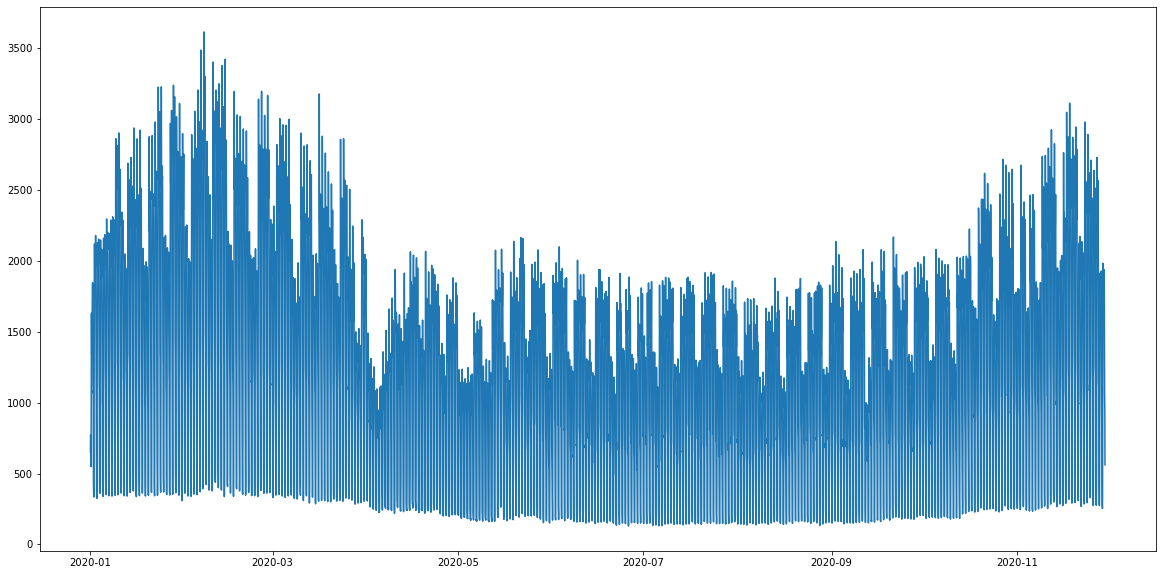

In [11]:
# график изменения температуры за весь период
fig = plt.subplots(1,1, figsize=(20,10))
plt.plot(df.index, df['power'])
plt.show()

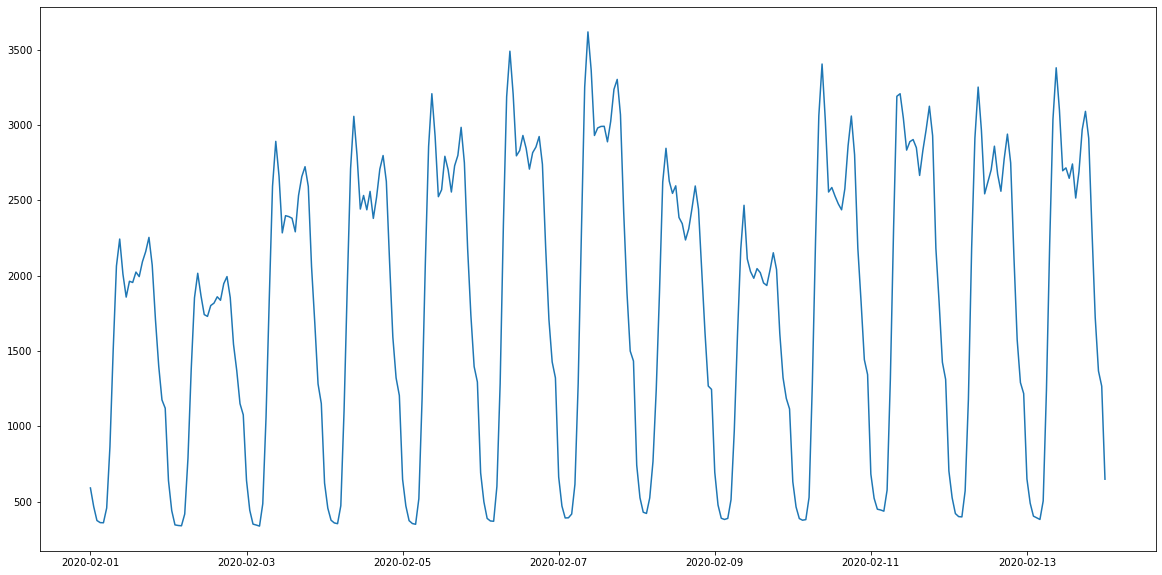

In [12]:
# посмотри выборочно две недели

fig = plt.subplots(1,1, figsize=(20,10))

plt.plot(df[(df.index>= '2020-02-01') & (df.index<='2020-02-14')].index, df[(df.index>= '2020-02-01') & (df.index<='2020-02-14')]['power'])

plt.show()

In [13]:
# добавим новые фичи: номер месяца, номер дня, день недели, час

df['month'] = df.index.month
df['day'] = df.index.day
df['day_of_week'] = df.index.dayofweek # 0 - monday
df['hour'] = df.index.hour
df

,power,t,month,day,day_of_week,hour
DateTime,,,,,,
2020-01-01 01:00:00,652.0,-5.2,1,1,2,1
2020-01-01 02:00:00,770.0,-5.2,1,1,2,2
2020-01-01 03:00:00,767.0,-5.2,1,1,2,3
2020-01-01 04:00:00,757.0,-5.2,1,1,2,4
2020-01-01 05:00:00,549.0,-5.2,1,1,2,5
...,...,...,...,...,...,...
2020-12-06 20:00:00,NaN,-8.8,12,6,6,20
2020-12-06 21:00:00,NaN,-8.8,12,6,6,21
2020-12-06 22:00:00,NaN,-8.8,12,6,6,22


In [14]:
# добавим лаги

def make_features(data, max_lag, rolling_mean_size):
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['power'].shift(lag)

    data['rolling_mean'] = round(data['power'].shift(max_lag).rolling(rolling_mean_size).mean(),2)

In [15]:
make_features(df, lags, ma_period)

In [16]:
#удалим строки с пустыми значениями, возникшими из-за расчета лагов и sма (simple moving average)

df.fillna(0, inplace=True, axis=1)
df = df.drop(df[df.index < '2020-01-02 02:00:00'].index) #drop rows with nan because of shift
df.

,power,t,month,day,day_of_week,hour,lag_1,lag_2,lag_3,lag_4,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,rolling_mean
DateTime,,,,,,,,,,,,,,,,,,,,,
2020-01-02 02:00:00,351.0,-2.3,1,2,3,2,434.0,603.0,1084.0,1070.0,...,1631.0,1503.0,836.0,692.0,549.0,757.0,767.0,770.0,652.0,0.0
2020-01-02 03:00:00,338.0,-2.3,1,2,3,3,351.0,434.0,603.0,1084.0,...,1447.0,1631.0,1503.0,836.0,692.0,549.0,757.0,767.0,770.0,0.0
2020-01-02 04:00:00,334.0,-2.3,1,2,3,4,338.0,351.0,434.0,603.0,...,1340.0,1447.0,1631.0,1503.0,836.0,692.0,549.0,757.0,767.0,0.0
2020-01-02 05:00:00,450.0,-2.3,1,2,3,5,334.0,338.0,351.0,434.0,...,1411.0,1340.0,1447.0,1631.0,1503.0,836.0,692.0,549.0,757.0,0.0
2020-01-02 06:00:00,803.0,-2.3,1,2,3,6,450.0,334.0,338.0,351.0,...,1501.0,1411.0,1340.0,1447.0,1631.0,1503.0,836.0,692.0,549.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-06 20:00:00,0.0,-8.8,12,6,6,20,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-06 21:00:00,0.0,-8.8,12,6,6,21,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-06 22:00:00,0.0,-8.8,12,6,6,22,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# поделим нашу выборку на обучающую и валидационную

target = df[df.index < '2020-11-30']['power']
features = df[df.index < '2020-11-30']
features = features.drop(['power'], axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, shuffle=False, random_state=12345)

In [18]:
features_train

,t,month,day,day_of_week,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,rolling_mean
DateTime,,,,,,,,,,,,,,,,,,,,,
2020-01-02 02:00:00,-2.3,1,2,3,2,434.0,603.0,1084.0,1070.0,1131.0,...,1631.0,1503.0,836.0,692.0,549.0,757.0,767.0,770.0,652.0,0.00
2020-01-02 03:00:00,-2.3,1,2,3,3,351.0,434.0,603.0,1084.0,1070.0,...,1447.0,1631.0,1503.0,836.0,692.0,549.0,757.0,767.0,770.0,0.00
2020-01-02 04:00:00,-2.3,1,2,3,4,338.0,351.0,434.0,603.0,1084.0,...,1340.0,1447.0,1631.0,1503.0,836.0,692.0,549.0,757.0,767.0,0.00
2020-01-02 05:00:00,-2.3,1,2,3,5,334.0,338.0,351.0,434.0,603.0,...,1411.0,1340.0,1447.0,1631.0,1503.0,836.0,692.0,549.0,757.0,0.00
2020-01-02 06:00:00,-2.3,1,2,3,6,450.0,334.0,338.0,351.0,434.0,...,1501.0,1411.0,1340.0,1447.0,1631.0,1503.0,836.0,692.0,549.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-19 15:00:00,16.9,7,19,6,15,1102.0,1135.0,1114.0,1075.0,1118.0,...,749.0,745.0,786.0,1158.0,1245.0,1229.0,1158.0,1181.0,1181.0,981.00
2020-07-19 16:00:00,16.9,7,19,6,16,1076.0,1102.0,1135.0,1114.0,1075.0,...,771.0,749.0,745.0,786.0,1158.0,1245.0,1229.0,1158.0,1181.0,981.09
2020-07-19 17:00:00,16.9,7,19,6,17,1116.0,1076.0,1102.0,1135.0,1114.0,...,375.0,771.0,749.0,745.0,786.0,1158.0,1245.0,1229.0,1158.0,980.45


## Оценка модели LinerRegression

In [19]:
# обучим модель LinerRegression и посчитаем среднеквадратичную ошибку 

l_regressor = LinearRegression()
l_regressor.fit(features_train, target_train)
target_predict_LR = l_regressor.predict(features_valid)
RMSE = mean_squared_error(target_valid, target_predict_LR) ** 0.5
print('RMSE: ', RMSE)

RMSE:  88.02818547782401


## Оценка модели LGBMRegressor

In [20]:
# обучим модель LGBMRegressor и посчитаем среднеквадратичную ошибку

param = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.005,
    "max_depth":10, 
    "n_estimators":500, 
    "num_leaves" : 1000, 
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': -1,
    "max_depth": 8,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 1000,
    "random_state":12345
}

lgbm_regressor = LGBMRegressor(**param)

lgbm_regressor.fit(features_train, target_train)
RMSE = mean_squared_error(target_valid, lgbm_regressor.predict(features_valid)) ** 0.5
print('RMSE: ', RMSE)

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
RMSE:  78.13094663491401



Ошибка меньше у LGBMRegressor. С ее помощью и сделаем прогноз


## Прогноз на необходимые 7 дней. Модель LGBMRegressor 

In [21]:
d = datetime(2020,11,30,1,0,0)

for t in range(7):
    features_predict = df[(df.index >= d) & (df.index < d + timedelta(days = 1))]
    features_predict = features_predict.drop('power', axis=1)

    result = lgbm_regressor.predict(features_predict, num_iteration=lgbm_regressor.best_iteration_)
    lo = [str(round(x,2)) for x in result]
    print(','.join(lo))
    
    j = 0
    for v in result:        
        if j == 24: 
            j = 0
            
        df.at[d, 'power'] = round(v,2)
        j += 1
        
        d = d + timedelta(hours = 1)
        
    make_features(df, lags, ma_period)

377.72,251.41,253.16,268.22,371.06,708.63,1252.65,1381.75,1296.5,1241.82,1240.46,1240.42,1240.25,1234.92,1234.95,1207.25,1263.74,1257.89,1219.6,1144.93,1043.63,966.24,914.31,463.87
355.52,220.41,221.96,231.94,363.17,672.2,1080.96,1151.65,1107.34,1043.35,1046.77,1044.01,1044.97,1015.71,1010.05,1005.57,1059.39,1053.45,1001.4,932.82,897.63,838.73,787.78,449.46
338.88,203.34,208.67,216.04,348.36,627.48,907.43,943.15,931.91,921.3,930.24,923.14,923.7,918.22,916.71,916.78,921.21,918.62,877.01,834.7,776.27,673.91,625.51,437.01
327.28,195.95,199.1,204.32,348.36,607.3,849.65,885.79,881.09,866.39,881.42,866.39,867.19,867.63,868.53,868.56,866.36,846.78,756.12,689.1,623.61,576.9,555.66,428.58
313.9,193.42,195.4,202.46,366.48,610.89,775.96,783.52,774.82,768.48,776.24,768.74,769.0,769.23,766.09,763.28,749.7,726.51,638.92,595.87,553.34,549.75,538.99,413.51
294.12,189.52,191.83,205.16,363.07,591.42,667.87,664.55,648.18,644.92,647.14,640.6,641.15,641.22,644.05,645.03,646.15,638.76,551.06,544.17,532.11,5


Ошибка небольшая. Но визуально данные кажутся заниженными. Попробуем прогноз библиотекой Skforecast


## Прогноз библиотекой Skforecast

In [22]:
# step - столько надо сделать прогнозных значений

step = 168

df_last = df[:-step][['power','t', 'month', 'day', 'hour', 'day_of_week']] #последние 168 значений это пустые 7 дней которые надо спрогнозировать

steps = round(len(df_last)*0.4) #step*2 # столько отрезаем в test


Train dates : 2020-01-02 02:00:00 --- 2020-07-19 20:00:00  (n=4795)
Test dates  : 2020-07-19 21:00:00 --- 2020-11-30 00:00:00  (n=3196)


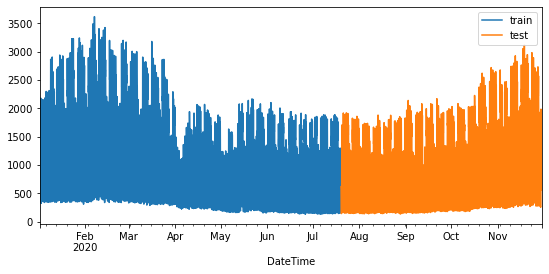

In [23]:
# поделим нашу выборку на обучающую и тестовую
# ==============================================================================

a = round(len(df_last)*0.4)

data_train = df_last[:-steps]
data_test  = df_last[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['power'].plot(ax=ax, label='train') # синим выборка,на которой будет обучаться модель 
data_test['power'].plot(ax=ax, label='test') # оранжевым выборка тестовая, на которой проверяем модель
ax.legend();

In [24]:
#обучаем модель

forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(**param),
                lags      = 24
             )

forecaster.fit(y=data_train['power'], exog=data_train[['t','month', 'day', 'hour', 'day_of_week']])
forecaster


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


ForecasterAutoreg 
Regressor: LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, feature_fraction=0.9,
              learning_rate=0.005, max_bin=512, max_depth=8,
              metric=['l1', 'l2'], n_estimators=500, num_iterations=1000,
              num_leaves=128, objective='regression', random_state=12345,
              task='train', verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['t', 'month', 'day', 'hour', 'day_of_week'] 
Training range: [0, 4794] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.005, 'max_depth': 8, 'min_child_samples': 20, 'min_child_weight'

In [25]:
# рассчитываем тестовый период
# ==============================================================================

predictions = forecaster.predict(steps=steps, exog=data_test[['t','month', 'day', 'hour', 'day_of_week']])

In [26]:
# рассчитываем ошибку
# ==============================================================================

error_mse = mean_squared_error(
                y_true = data_test['power'],
                y_pred = predictions
            )

print(f"Test error (rmse): {error_mse**0.5}")

Test error (rmse): 267.2238055923555


In [27]:
# оптимизируем гиперпараметры модели перебором по сетке
# ==============================================================================

forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(**param),
                #regressor = RandomForestRegressor(random_state=123),
                lags      = 24 # This value will be replaced in the grid search
             )

lags_grid = [12, 24, 25]

param_grid = {'n_estimators': [500, 1000],
              'max_depth': [5, 10]}

results_grid = grid_search_forecaster(
                    forecaster  = forecaster,
                    y           = data_train['power'],
                    exog        = data_train[['t','month', 'day', 'hour', 'day_of_week']],
                    param_grid  = param_grid,
                    lags_grid   = lags_grid,
                    steps       = step,
                    refit       = True,
                    metric      = 'mean_squared_error',
                    initial_train_size = int(len(data_train)*0.5),
                    return_best = True,
                    verbose     = False
               )

Number of models compared: 12.


loop param_grid:   0%|                                              | 0/4 [00:00<?, ?it/s]

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 


loop param_grid:  25%|█████████▌                            | 1/4 [00:18<00:55, 18.45s/it]

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 


loop param_grid:  50%|███████████████████                   | 2/4 [00:36<00:36, 18.23s/it]

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 


loop param_grid:  75%|████████████████████████████▌         | 3/4 [01:22<00:30, 30.91s/it]

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 


loop param_grid:   0%|                                              | 0/4 [00:00<?, ?it/s]

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 


loop param_grid:  25%|█████████▌                            | 1/4 [00:27<01:21, 27.10s/it]

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 


loop param_grid:  50%|███████████████████                   | 2/4 [00:52<00:52, 26.03s/it]

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 


loop param_grid:  75%|████████████████████████████▌         | 3/4 [01:52<00:41, 41.41s/it]

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 


loop param_grid:   0%|                                              | 0/4 [00:00<?, ?it/s]

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 


loop param_grid:  25%|█████████▎                           | 1/4 [10:49<32:27, 649.08s/it]

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 


loop param_grid:  50%|██████████████████▌                  | 2/4 [11:21<09:32, 286.44s/it]

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 


loop param_grid:  75%|███████████████████████████▊         | 3/4 [12:23<03:03, 183.92s/it]

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 


loop lags_grid: 100%|██████████████████████████████████████| 3/3 [18:23<00:00, 367.67s/it]


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'max_depth': 10, 'n_estimators': 500}
  Backtesting metric: 25091.27622508626



In [28]:
# сделаем прогноз на тестовой выборке с подобранными параметрами модели 
# ==============================================================================

predictions = forecaster.predict(steps=steps, exog=data_test[['t','month', 'day', 'hour', 'day_of_week']])
print(predictions)

24       660.082574
25       620.296027
26       622.143067
27       358.501103
28       226.972208
           ...     
3215    1118.383293
3216     916.415365
3217     732.701865
3218     679.031705
3219     389.549513
Name: pred, Length: 3196, dtype: float64


In [30]:
# Test error
# ==============================================================================

error_mse = mean_squared_error(y_true = data_test['power'], y_pred = predictions)
print(f"Test error (rmse) {error_mse**0.5}")

Test error (rmse) 286.14096484801667


Модель обучена. Параметры подобраны. Сделаем прогноз на 21 день, из которых последние 7 необходимые в задаче, так как при делении на тестовую и обучаемую выбоки, 14 последних дней данных отводились под тестовую базу и в обучении не участвовали.

In [31]:
# делаем прогноз на 3 недели (2 последние недели из выборки и одна нам нужная по условиям задачи)
# ==============================================================================

t_predict = df[-(steps+step):][['t','month', 'day', 'hour', 'day_of_week']] #берем температру отрезанную в тест и температуру прогнозных дней
predictions21 = forecaster.predict(steps=(steps+step), exog=t_predict[['t','month', 'day', 'hour', 'day_of_week']])
print(predictions21)

24       660.082574
25       620.296027
26       622.143067
27       358.501103
28       226.972208
           ...     
3383    1202.594648
3384    1016.177764
3385     727.346901
3386     646.114704
3387     387.249252
Name: pred, Length: 3364, dtype: float64


In [32]:
# выводим полученные почасовые прогнозные значения с 30.11.2020 по 06.12.2020

lo = [str(round(x,2)) for x in predictions21[:-step]]
# print(len(lo))
print(','.join(lo[:-step]))

660.08,620.3,622.14,358.5,226.97,165.53,163.04,160.34,173.13,509.7,1158.14,1620.12,1805.21,1621.88,1483.46,1539.34,1545.83,1539.96,1473.14,1493.67,1600.89,1714.76,1560.78,966.54,782.32,707.28,698.81,393.33,240.09,176.71,171.13,164.94,184.25,504.1,1132.44,1710.43,1896.06,1685.98,1483.29,1541.23,1578.11,1616.34,1528.24,1527.01,1659.7,1795.7,1562.92,1009.77,816.77,753.27,767.3,404.29,240.39,180.31,175.02,169.38,185.43,494.15,1115.63,1646.07,1868.27,1651.88,1459.37,1522.48,1552.98,1579.74,1521.28,1527.23,1645.53,1761.23,1534.37,1021.01,799.01,739.64,730.3,386.42,241.49,182.17,177.76,174.33,190.48,492.54,1101.7,1615.59,1829.79,1607.42,1431.1,1491.42,1511.58,1542.12,1489.95,1510.56,1640.82,1744.34,1559.13,1044.91,805.39,743.0,728.36,383.7,238.66,187.39,179.74,175.58,194.99,476.88,1072.25,1561.7,1802.87,1604.94,1426.9,1475.81,1484.58,1501.13,1472.72,1512.22,1632.94,1739.3,1551.78,1094.38,815.24,744.65,747.09,384.7,237.65,188.26,179.41,176.81,194.16,417.58,865.13,1179.95,1293.72,1142.34,1061.8

Сделаем прогноз с подобранными параметрами по полной базе без деления. В результате делаем прогноз только на заданные в задаче 7 дней

In [33]:
# обучаем модель на всех данных с 01.01.2020 по 29.11.2020

data_train7 = df[:-step][['power','t','month', 'day', 'hour', 'day_of_week']] #все кроме пустых прогнозных дней
t_predict7 = df[-step:][['t','month', 'day', 'hour', 'day_of_week']] #температура из прогнозных дней

forecaster7 = ForecasterAutoreg(
                regressor = LGBMRegressor(**param),
                lags      = 25
             )

forecaster7.fit(y=data_train7['power'], exog=data_train7[['t','month', 'day', 'hour', 'day_of_week']])
forecaster7

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


ForecasterAutoreg 
Regressor: LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, feature_fraction=0.9,
              learning_rate=0.005, max_bin=512, max_depth=8,
              metric=['l1', 'l2'], n_estimators=500, num_iterations=1000,
              num_leaves=128, objective='regression', random_state=12345,
              task='train', verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25] 
Transformer for y: None 
Transformer for exog: None 
Window size: 25 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['t', 'month', 'day', 'hour', 'day_of_week'] 
Training range: [0, 7990] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.005, 'max_depth': 8, 'min_child_samples': 20, 'min_child_wei

In [34]:
# делаем прогноз на 7 дней
# ==============================================================================

predictions7 = forecaster7.predict(steps=step, exog=t_predict7[['t','month', 'day', 'hour', 'day_of_week']])
lo = [str(round(x,2)) for x in predictions7]
print(','.join(lo))

363.88,271.45,267.19,268.38,377.76,837.85,1674.89,2287.82,2388.32,2247.96,1998.48,2002.52,2042.17,2037.78,1981.54,2032.09,2215.57,2318.99,2117.04,1495.09,1172.54,1070.32,1049.78,575.61,372.9,277.3,272.03,276.5,406.09,864.69,1568.83,2166.33,2363.14,2160.03,1929.42,1966.17,2011.58,2021.04,1976.06,2038.07,2182.87,2298.19,2110.94,1491.35,1158.29,1046.87,996.9,566.47,377.21,294.76,280.87,294.74,400.01,883.56,1649.14,2221.18,2406.33,2241.54,1971.26,1994.29,2044.6,2029.33,1980.01,2039.48,2200.65,2312.36,2144.73,1518.98,1152.98,1052.85,1005.61,568.1,378.56,306.96,298.77,304.1,388.64,902.11,1679.23,2233.62,2420.65,2240.88,1975.31,2000.19,2046.31,2028.36,1979.87,2044.97,2200.83,2316.08,2145.73,1525.33,1152.54,1052.0,1003.18,569.27,382.1,315.71,310.16,311.47,393.27,885.67,1630.23,2209.72,2415.67,2246.47,1974.53,1993.31,2042.74,2026.02,1981.52,2041.95,2196.39,2309.73,2141.98,1535.09,1149.0,1052.78,991.49,569.4,384.24,315.31,308.48,304.94,383.22,759.22,1263.57,1719.17,1909.54,1745.13,1610.81,1645.9

# Вывод

Мне были даны показания потребления за 11 месяцев года. Требовалось сделать прогноз на 7 дней. В данных наблюдалась цикличность потребления в течения дня: ночью меньше, днем значительно больше. Кроме того, в данных видна сезонность: зимой высокое потребление, самый пик был в феврале, затем снижается весной, самое низкое в апреле, затем снова незначительный рост и одинаковое потребление в течении лета до середины октября, затем снова начинается рост.

Я разделила имеющиеся данные на две выборки: обучающую и тестовую. Обучила две модели, LinerRegression и LGBMRegressor, и сравнила их среднеквадратичные ошибки. Меньшей оказалась ошибка у LGBMRegressor. С помощью этой модели посчитала прогноз на нужные 7 дней.

Но визуально данные кажутся заниженными. Поэтому сделала прогноз библиотекой Skforecast.

Последние полученные данные и занесла в таблицу.

В дальнейшем можно оценить как работает текущая модель, насколько точный она дает прогноз. Если прогнозируемые данные будут не достаточно точны, можно попробовать использовать другие модели прогнозирования временных рядов.
Например, для снижения ошибки прогнозирования можно будет поработать с цикличностью, привести рассматриваемый временной ряд к стационарному и сделать прогноз с помощью модели ARIMA, sARIMA.